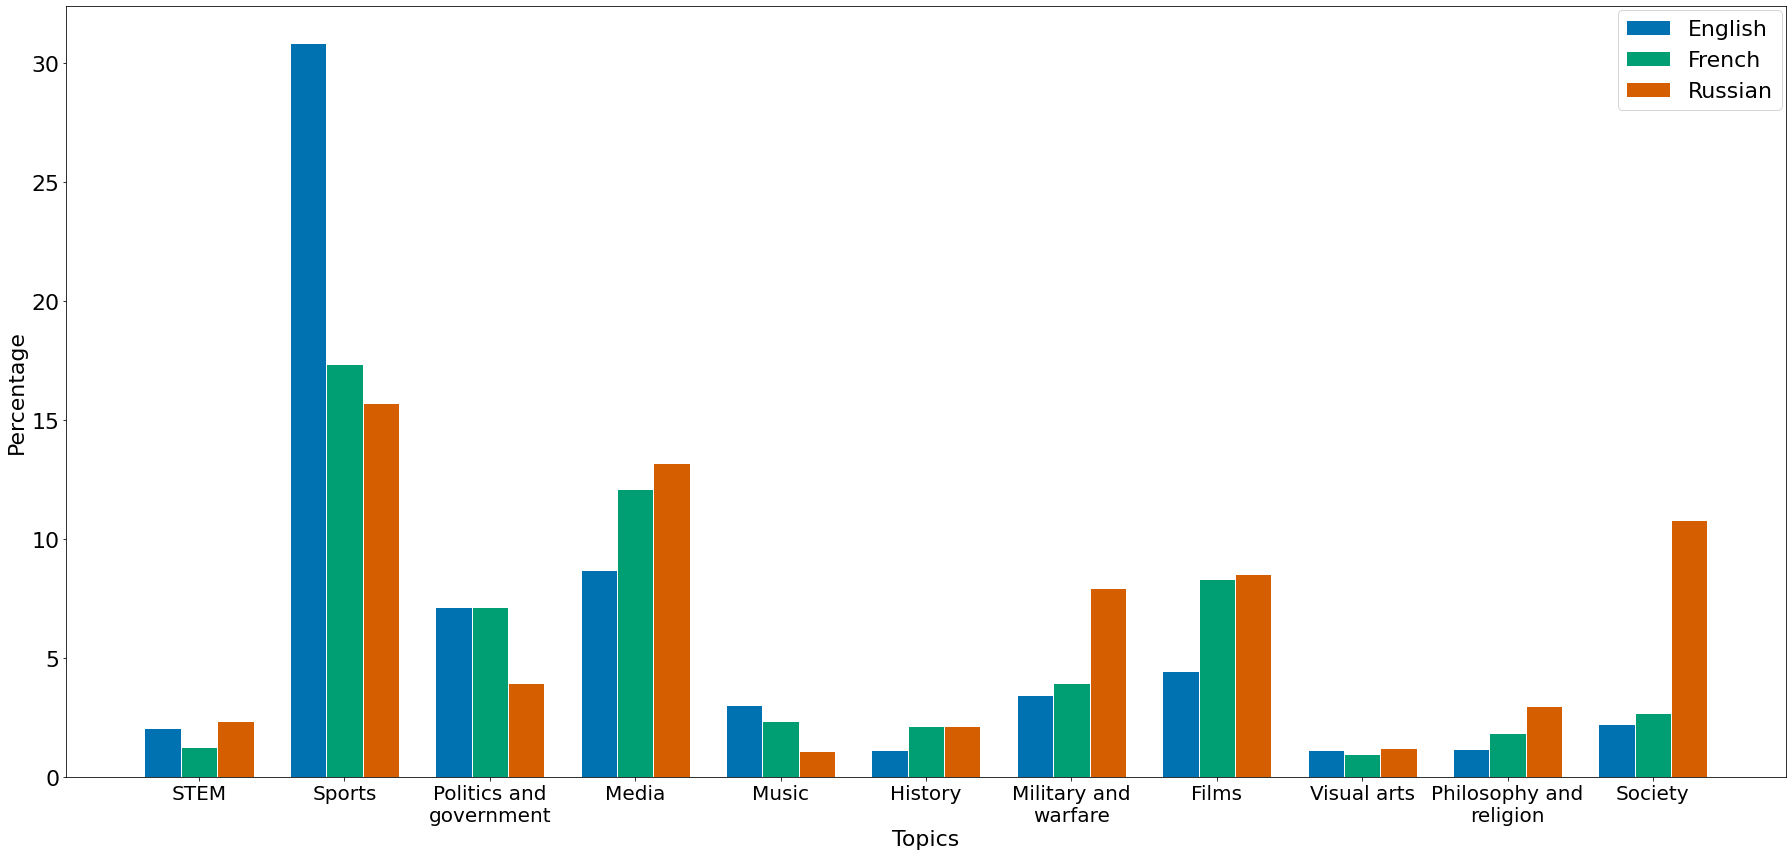

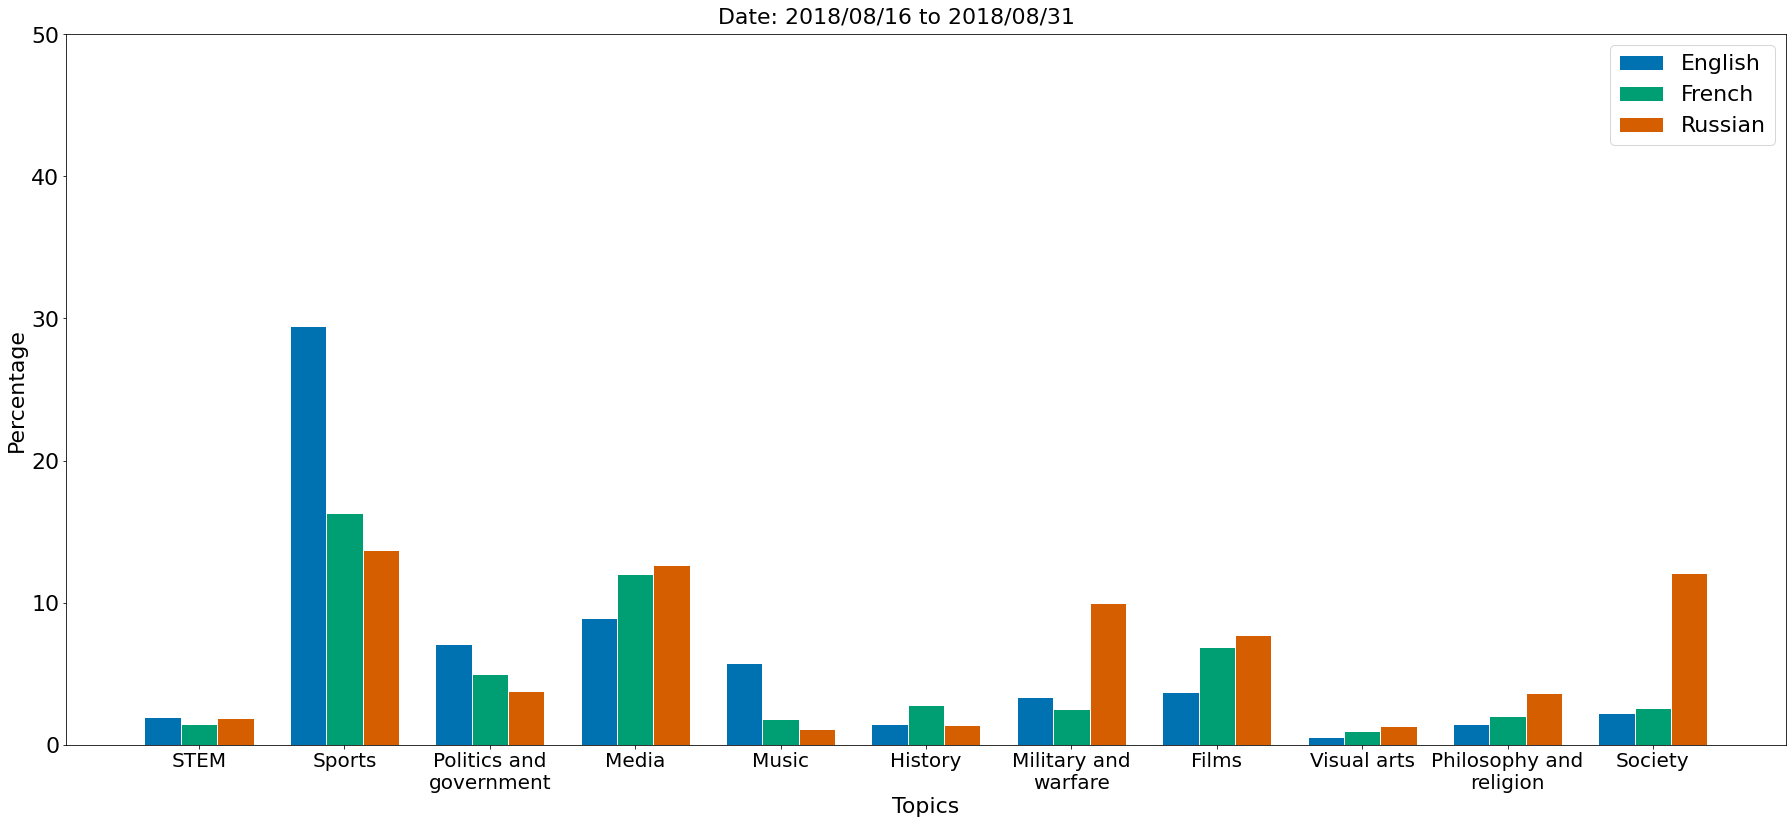

In [5]:
import IPython
import numpy as np
import networkx as nx
import requests
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import time
import community
from fonctions import *
from pylab import rcParams


### Layout parameters
plt.style.use('seaborn-colorblind')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['figure.figsize'] = 25, 12
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 22


### Variables for the following pipeline

pd.set_option('mode.chained_assignment', None)

path_en = 'Results/EN/EN_'
path_fr = 'Results/FR/FR_'
path_ru = 'Results/RU/RU_'

list_date = ['20180816_20180831', '20180901_20180915', '20180916_20180930', '20181001_20181015', 
            '20181016_20181031', '20181101_20181115',  '20181116_20181130', '20181201_20181215',
            '20181216_20181231']

list_topic = ['STEM*', 'Sports', 'Politics_and_government', 'Media*', 'Music', 'History', 'Military_and_warfare',
             'Films', 'Visual_arts*', 'Philosophy_and_religion', 'Society']




def count_topics(date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    

    df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
    df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
    df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

    count_en = df_en[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_fr = df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum()
    count_ru = df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum()

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)





def count_total_topics(list_date):
    
    count_en, count_fr, count_ru = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    
    for date in list_date:
            
        df_en = pd.read_csv(path_en + date + '/list_cluster_topic.csv')
        df_fr = pd.read_csv(path_fr + date + '/list_cluster_topic.csv')
        df_ru = pd.read_csv(path_ru + date + '/list_cluster_topic.csv')

        count_en = count_en.add(df_en[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_fr = count_fr.add(df_fr[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)
        count_ru = count_ru.add(df_ru[['Subtopic', 'Count']].groupby('Subtopic').sum(), fill_value=0)

    count_en['Ratio'] = ((count_en['Count'] / count_en['Count'].sum()) * 100)
    count_fr['Ratio'] = ((count_fr['Count'] / count_fr['Count'].sum()) * 100)
    count_ru['Ratio'] = ((count_ru['Count'] / count_ru['Count'].sum()) * 100)

    return count_en.sort_values(by="Count", ascending=False), count_fr.sort_values(by="Count", ascending=False), count_ru.sort_values(by="Count", ascending=False)
    

    

def display_topics_comparison(ratio_en, ratio_fr, ratio_ru, list_topic):
    fig = plt.figure()

    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars_en, bars_fr, bars_ru = [], [], []

    for tp in list_topic:
        bars_en.append(list(ratio_en.loc[ratio_en.index.str.contains(tp)])[0])
        bars_fr.append(list(ratio_fr.loc[ratio_fr.index.str.contains(tp)])[0])
        bars_ru.append(list(ratio_ru.loc[ratio_ru.index.str.contains(tp)])[0])

    # Set position of bar on X axis
    r1 = np.arange(len(bars_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]


    
    plt.bar(r1, bars_en, width=barWidth, edgecolor='white', label='English')
    plt.bar(r2, bars_fr, width=barWidth, edgecolor='white', label='French')
    plt.bar(r3, bars_ru, width=barWidth, edgecolor='white', label='Russian')

    # Add xticks on the middle of the group bars
    
    
    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    l_topic[2]=l_topic[2][0:12] + '\n' + l_topic[2][13:]
    l_topic[6]=l_topic[6][0:12] + '\n' + l_topic[6][13:]
    l_topic[9]=l_topic[9][0:14] + '\n' + l_topic[9][15:]
    
    plt.xticks([r + barWidth for r in range(len(bars_en))], l_topic, rotation='horizontal')
    
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    
    
    fig.tight_layout()
    # Create legend & Show graphic
    fig.legend(fontsize=22)
    plt.show()
    fig.savefig("Figures/topic_distribution.pdf", bbox_inches='tight')
    
    

def barlist(n): 
    bars_en, bars_fr, bars_ru = [], [], []
    df_en, df_fr, df_ru = count_topics(list_date[n])
    for tp in list_topic:
        bars_en.append(list(df_en.loc[df_en.index.str.contains(tp), 'Ratio'].values)[0])
        bars_fr.append(list(df_fr.loc[df_fr.index.str.contains(tp), 'Ratio'].values)[0])
        bars_ru.append(list(df_ru.loc[df_ru.index.str.contains(tp), 'Ratio'].values)[0])
    return bars_en, bars_fr, bars_ru    
    
    
    
def topic_evolution(list_topic, list_date):
    fig= plt.figure()
    barWidth = 0.25
    
    ax=plt.axes()
    ax.set_ylim(0, 50)
    
    n=len(list_date) #Number of frames
    
    bar_en, bar_fr, bar_ru = barlist(0)
    
    r1=range(len(bar_en))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    barcollection_en = plt.bar(r1, bar_en, width=barWidth, edgecolor='white', label='English')
    barcollection_fr = plt.bar(r2, bar_fr, width=barWidth, edgecolor='white', label='French')
    barcollection_ru = plt.bar(r3, bar_ru, width=barWidth, edgecolor='white', label='Russian')
    
    # Making date more readable 
    date_title = []
    for date in list_date:
        date_title.append(date[0:4]+'/'+date[4:6]+'/'+date[6:8]+' to '+date[9:13]+'/'+date[13:15]+'/'+date[15:17])

    def animate(i):
        y_en, y_fr, y_ru = barlist(i)
        fig.suptitle('Date: ' + date_title[i], fontsize=22)
        for n, b in enumerate(barcollection_en):
            b.set_height(y_en[n])
        for n, b in enumerate(barcollection_fr):
            b.set_height(y_fr[n])
        for n, b in enumerate(barcollection_ru):
            b.set_height(y_ru[n])
        
    anim=FuncAnimation(fig, animate, repeat=True, blit=False, frames=n, interval=1000)
    
    # Making labels looks nicer
    l_topic = list_topic.copy()
    for i in range(len(l_topic)): 
        l_topic[i] = l_topic[i].replace("_", " ")
        if ('*' in l_topic[i]):
            l_topic[i] = l_topic[i].replace("*", "")
    l_topic[2]=l_topic[2][0:12] + '\n' + l_topic[2][13:]
    l_topic[6]=l_topic[6][0:12] + '\n' + l_topic[6][13:]
    l_topic[9]=l_topic[9][0:14] + '\n' + l_topic[9][15:]
    
    plt.xticks([r + barWidth for r in range(len(list_topic))], l_topic, rotation='horizontal')
    plt.xlabel('Topics', fontsize=22)
    plt.ylabel('Percentage', fontsize=22)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.legend(fontsize=22)
    plt.show()
    anim.save('Figures/bar.gif', writer='pillow')
    

    


    
count_en, count_fr, count_ru = count_total_topics(list_date)

display_topics_comparison(count_en['Ratio'], count_fr['Ratio'], count_ru['Ratio'], list_topic)

topic_evolution(list_topic, list_date)    

In [3]:
count_en

,Count,Ratio
Subtopic,,
Sports,8743.0,30.831893
Media*,2460.0,8.675107
Politics_and_government,2021.0,7.126988
North_America,1785.0,6.294742
Films,1261.0,4.446874
...,...,...
Central_Asia,5.0,0.017632
Southern_Africa,4.0,0.014106
Biography*,3.0,0.010579
